<a href="https://colab.research.google.com/github/yuannnnn/DATS6501/blob/main/DamageSeverityvgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading & Processing

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

curr = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
import os

if "crisis_vision_benchmarks" not in os.listdir():
    os.system("wget https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz")
    os.system("tar xf crisis_vision_benchmarks.tar.gz")

In [ ]:
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.pre = os.getcwd() + "/crisis_vision_benchmarks"
        path = pd.read_csv(path, sep='\t')
        image_path, class_label = path['image_path'], path['class_label']
        self.img, lab = [], []
        for i in range(len(class_label)):
          if class_label[i] != 'other_disaster':
            self.img.append(image_path[i])
            lab.append(class_label[i])
        self.le = LabelEncoder()
        self.le.fit(lab)
        self.labels = self.le.transform(lab)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def le(self):
        return self.le

    def __getitem__(self, idx):
        img_path = os.path.join(self.pre, self.img[idx])
        with open(img_path, 'rb') as f:
          img = Image.open(f) 
          image = img.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop([299,299]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "dev": transforms.Compose([
        transforms.Resize([310,310]),
        transforms.CenterCrop([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

damage_root = "/content/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_"

damage_dataset = {x: CustomImageDataset(damage_root + x + "_final.tsv", data_transforms[x])
                  for x in ["train", "dev"]}

damage_loader = {x: DataLoader(damage_dataset[x], batch_size=64,
                                             shuffle=True, num_workers=2)
                  for x in ["train", "dev"]}
              
damage_size = {x: len(damage_dataset[x]) for x in ["train", "dev"]}

damage_names = damage_dataset['train'].le.classes_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
damage_test = CustomImageDataset(damage_root + "test_final.tsv", data_transforms["dev"])

test_loader = DataLoader(damage_test, batch_size=64,
                                             shuffle=True, num_workers=2)

In [ ]:
len(damage_dataset["train"]),len(damage_dataset["dev"]),len(damage_test)

(28319, 2712, 3865)

In [ ]:
damage_names

array(['little_or_none', 'mild', 'severe'], dtype='<U14')

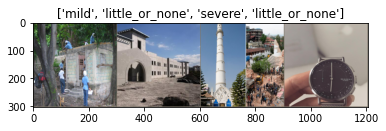

Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Change the Tensor to array and change color channel to the last
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(damage_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[damage_names[x] for x in classes[:4]])

print(f"Feature batch shape: {inputs.size()}")
print(f"Labels batch shape: {classes.size()}")

# Data Modeling & Training

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

In [ ]:
def train_damage(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in damage_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / damage_size[phase]
            epoch_acc = running_corrects.double() / damage_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.vgg16(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# change the number of classes 
model_ft.classifier[6].out_features = len(damage_names)
# freeze convolution weights
for param in model_ft.features.parameters():
    param.requires_grad = False

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
model_damage = train_damage(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6413 Acc: 0.7465
dev Loss: 0.6831 Acc: 0.7164

Epoch 1/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6117 Acc: 0.7587
dev Loss: 0.6893 Acc: 0.7205

Epoch 2/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5911 Acc: 0.7643
dev Loss: 0.6745 Acc: 0.7205

Epoch 3/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5856 Acc: 0.7667
dev Loss: 0.6680 Acc: 0.7176

Epoch 4/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5678 Acc: 0.7753
dev Loss: 0.6853 Acc: 0.7128

Epoch 5/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5636 Acc: 0.7767
dev Loss: 0.6577 Acc: 0.7220

Epoch 6/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5205 Acc: 0.7933
dev Loss: 0.6380 Acc: 0.7294

Epoch 7/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5112 Acc: 0.7981
dev Loss: 0.6318 Acc: 0.7312

Epoch 8/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5006 Acc: 0.8015
dev Loss: 0.6329 Acc: 0.7316

Epoch 9/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4921 Acc: 0.8015
dev Loss: 0.6310 Acc: 0.7305

Epoch 10/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4898 Acc: 0.8041
dev Loss: 0.6268 Acc: 0.7334

Epoch 11/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4901 Acc: 0.8038
dev Loss: 0.6300 Acc: 0.7268

Epoch 12/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4882 Acc: 0.8054
dev Loss: 0.6261 Acc: 0.7334

Epoch 13/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4828 Acc: 0.8095
dev Loss: 0.6269 Acc: 0.7316

Epoch 14/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4778 Acc: 0.8097
dev Loss: 0.6247 Acc: 0.7308

Training complete in 198m 54s
Best val Acc: 0.733407


In [ ]:
torch.save(model_damage.state_dict(), curr+"model_damage3.pth")

# Load Trained Net

In [ ]:
model_ft = models.vgg16(pretrained=False)
# change the number of classes 
model_ft.classifier[6].out_features = len(types_names)
# freeze convolution weights
for param in model_ft.features.parameters():
    param.requires_grad = False

model_ft.load_state_dict(torch.load(curr+"model_damage3.pth"))

model_ft = model_ft.to(device)

In [ ]:
preds, real = [], []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  real += labels.tolist()
  with torch.no_grad():
    output = model_ft(images)
    _, predicted = torch.max(output, 1)
    preds += predicted.tolist()

In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(real, preds, target_names=damage_names))

                precision    recall  f1-score   support

little_or_none       0.84      0.87      0.85      2135
          mild       0.51      0.24      0.33       629
        severe       0.67      0.83      0.74      1101

      accuracy                           0.75      3865
     macro avg       0.67      0.65      0.64      3865
  weighted avg       0.74      0.75      0.73      3865



In [ ]:
import seaborn as sns

cm = metrics.confusion_matrix(real, preds)
f = sns.heatmap(cm, annot=True, xticklabels=types_names, yticklabels=types_names)
plt.title("Confusion Matrix")
plt.xlabel("Actual Disasters")
plt.ylabel("Predicted Disasters") 
plt.show()

# Codes borrowed and adjusted from:


1.  [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
2.  [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
3.  [Transfer Learning with PyTorch](https://debuggercafe.com/transfer-learning-with-pytorch/)


